In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr

# Configuration

### Inputs

In [2]:
process_out_dir = '../../01_process/out/'
test_out_dir = '../../04_test/out/'

# data, primarily for the ice flags
soft_test_data_fpath = process_out_dir + 'soft_test_data.npz'
test_data_fpath = process_out_dir + 'test_data.npz'

# associated predictions
soft_test_preds_fpath = test_out_dir + 'massive_lstm_soft_test_preds_1_.npy'
test_preds_fpath = test_out_dir + 'massive_lstm_test_preds_1_.npy'

eval_metrics_fpath = '../out/massive_lstm_test_metrics_1_.npz'

mapping_reference = "../../01_process/in/MN_ice/raw_data_from_DNR/lake_ice_id_spreadsheet.xlsx"

# Import data

In [3]:
# Import both testing partitions
soft_test_data = np.load(soft_test_data_fpath, allow_pickle = True)
test_data = np.load(test_data_fpath, allow_pickle = True)

# Extract everything from soft testing partition
soft_test_x = soft_test_data['x']
soft_test_y = soft_test_data['y']
soft_test_dates = soft_test_data['dates']
soft_test_DOW = soft_test_data['DOW']
soft_test_variables = soft_test_data['features']

# Extract everything from testing partition
test_x = test_data['x']
test_y = test_data['y']
test_dates = test_data['dates']
test_DOW = test_data['DOW']
test_variables = test_data['features']

# Import associated predictions
soft_test_preds = np.load(soft_test_preds_fpath)
test_preds = np.load(test_preds_fpath)

In [4]:
# Separate the two types of soft testing data
train_years_test_lakes_ids = np.argwhere(soft_test_data['dates'][:, 0] < test_data['dates'].min()).flatten()
test_years_train_lakes_ids = np.argwhere(soft_test_data['dates'][:, 0] >= test_data['dates'].min()).flatten()

train_years_test_lakes_preds = soft_test_preds[train_years_test_lakes_ids]
train_years_test_lakes_x = soft_test_x[train_years_test_lakes_ids]
train_years_test_lakes_y = soft_test_y[train_years_test_lakes_ids]
train_years_test_lakes_dates = soft_test_dates[train_years_test_lakes_ids]

test_years_train_lakes_preds = soft_test_preds[test_years_train_lakes_ids]
test_years_train_lakes_x = soft_test_x[test_years_train_lakes_ids]
test_years_train_lakes_y = soft_test_y[test_years_train_lakes_ids]
test_years_train_lakes_dates = soft_test_dates[test_years_train_lakes_ids]

In [5]:
# Programmatically identify process-based ice flag data
ice_var_idx = int(np.argwhere(test_variables == 'ice'))
depth_var_idx = int(np.argwhere(test_variables == 'MaxDepth'))
area_var_idx = int(np.argwhere(test_variables == 'LakeArea'))
assert soft_test_variables[ice_var_idx] == 'ice'
assert soft_test_variables[depth_var_idx] == 'MaxDepth'
assert soft_test_variables[area_var_idx] == 'LakeArea'

In [6]:
eval_metrics = np.load(eval_metrics_fpath, allow_pickle = True)

# Plot some simple time series

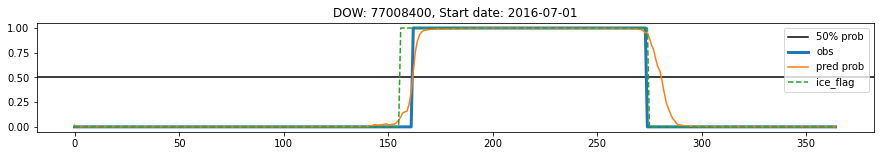

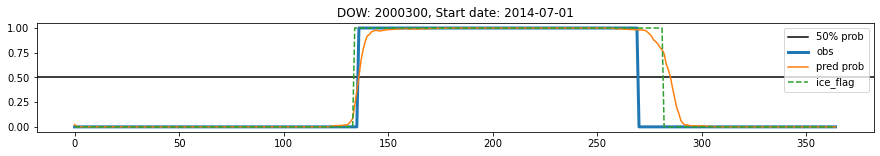

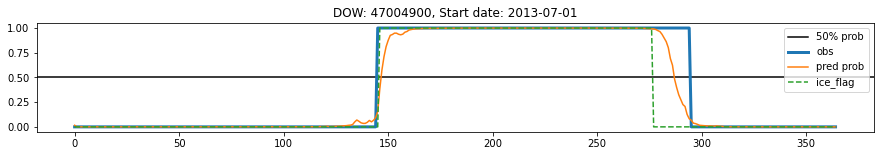

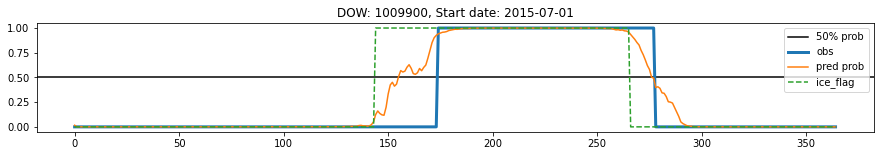

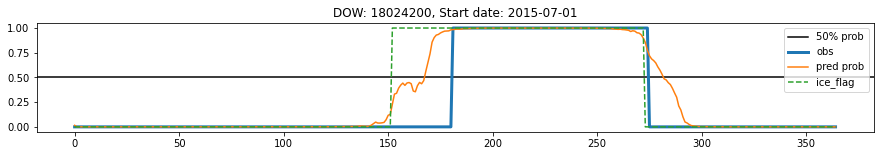

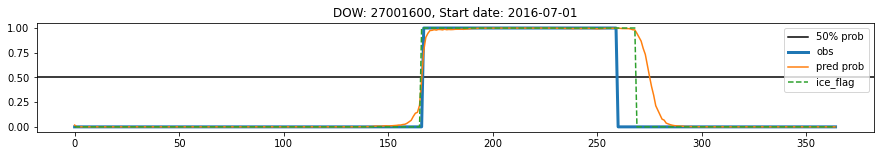

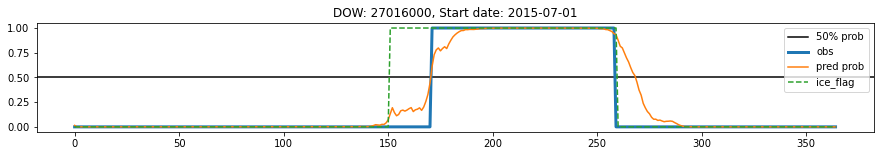

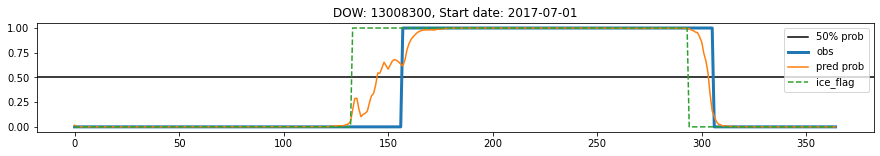

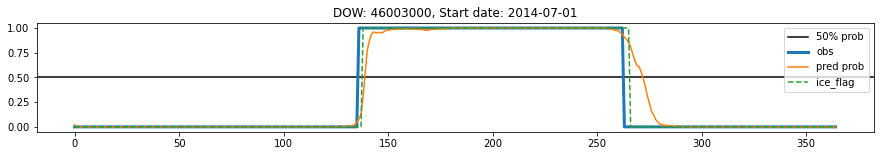

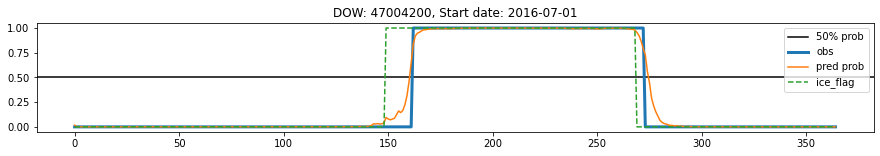

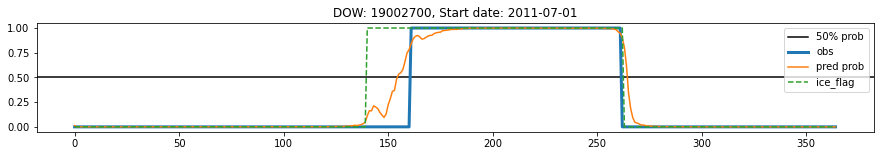

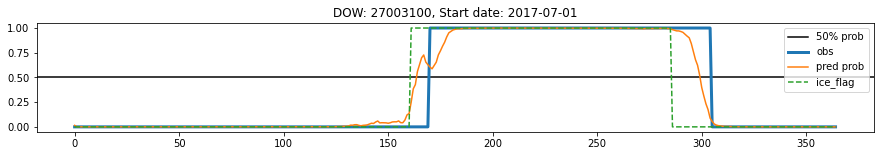

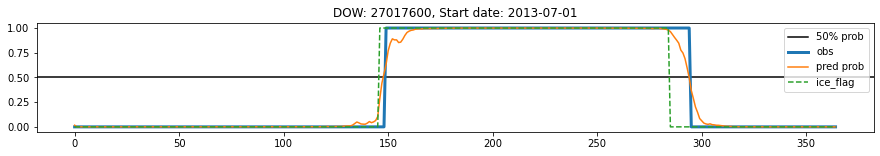

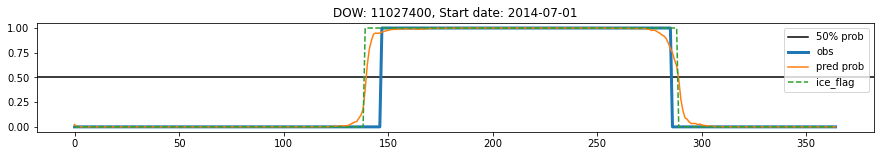

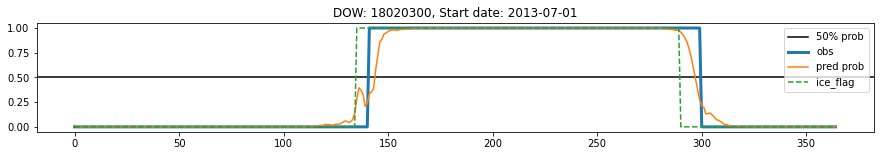

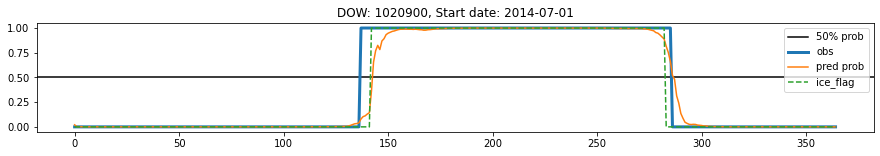

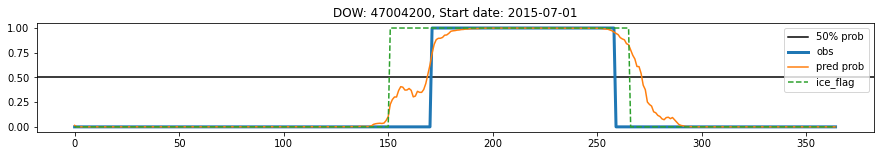

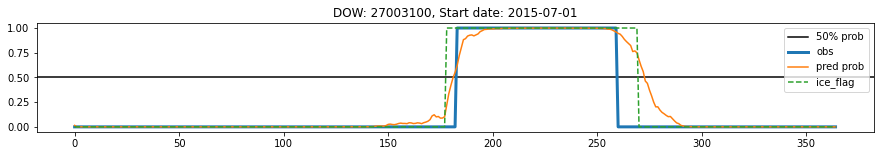

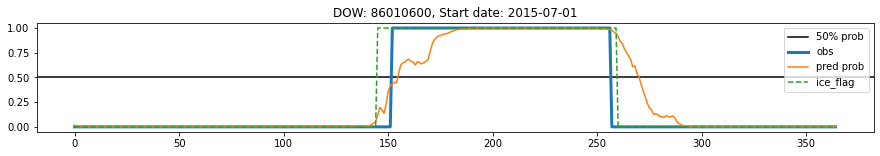

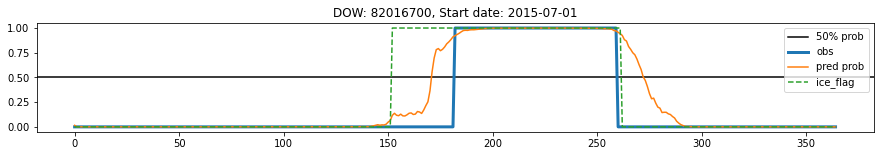

In [8]:
# Seed to view the same ones each time
np.random.seed(123)

# 10 random time series plots
# Includes:
#   Observation
#   Prediction
#   PB ice flag
#   50% probability line
#   Date and DOW of time series
for i in range(20):
    rand_i = np.random.choice(test_preds.shape[0])

    plt.figure(figsize = (15, 2))
    plt.axhline(0.5, label = '50% prob', color = 'black')
    plt.plot(test_y[rand_i, :], label = 'obs', linewidth = 3)
    plt.plot(test_preds[rand_i, :, 0], label = 'pred prob')
    plt.plot(test_x[rand_i, :, ice_var_idx], label = 'ice_flag', linestyle = '--')
    plt.title('DOW: ' + str(test_DOW[rand_i]) + ', Start date: ' + test_dates[rand_i][0])
    plt.legend();

# Spatial distribution

In [10]:
# Read in the MN lake metadata, focusing on coordiantes and lake size
lat_lon_ref_df = pd.read_excel(mapping_reference,
                               usecols=['dow num', 'lat', 'long', 'acres'])
lat_lon_ref_df = lat_lon_ref_df.rename(columns = {'dow num':'DOW'})

# Merge that information with the validation set DOWs
seq_DOWs = pd.DataFrame({'DOW':test_DOW})
mapping_df = seq_DOWs.merge(lat_lon_ref_df, on='DOW', how = 'left')

In [13]:
# Assign all the errors to that newly merged dataframe
# (both are sorted by validation set DOW)
mapping_df['flag_error_ice_on'] = eval_metrics['test_flag_error_ice_on']
mapping_df['flag_error_ice_off'] = eval_metrics['test_flag_error_ice_off']
mapping_df['flag_error_dur']  = eval_metrics['test_flag_error_dur'] 
mapping_df['pred_error_ice_on']  = eval_metrics['test_pred_error_ice_on'] 
mapping_df['pred_error_ice_off'] = eval_metrics['test_pred_error_ice_off'] 
mapping_df['pred_error_dur'] = eval_metrics['test_pred_error_dur']

In [14]:
def map_error(error_col_suffix, jitter):
    # Craft the two column names
    process_based_col = 'flag_' + error_col_suffix
    new_model_col = 'pred_' + error_col_suffix
    
    # Set the colors to map to the same values
    cmap_extreme = np.max(np.abs([mapping_df[new_model_col].min(),
                                  mapping_df[new_model_col].max()]))
    
    # Configure a 2-plot arangement
    fig, ax = plt.subplots(1, 3, figsize = (13, 6), gridspec_kw={'width_ratios': [6, 6, 0.5]})
    
    # Create the spatial jitter values (same for both subplots)
    lat_jitter = np.random.normal(loc = 0, scale = jitter, size = mapping_df.shape[0])
    lon_jitter = np.random.normal(loc = 0, scale = jitter, size = mapping_df.shape[0])
    
    # Plot ice flag errors with spatial jitter
    # Size and color are mapped to error
    ax[0].set_title("Process-based Ice Flags")
    ax[0].scatter(mapping_df['long'] + lon_jitter,
                  mapping_df['lat'] + lat_jitter,
                  s = np.abs(mapping_df[process_based_col]*3),
                  marker = 'o',
                  cmap = 'BrBG',
                  vmin = -1*cmap_extreme,
                  vmax = cmap_extreme,
                  c = mapping_df[process_based_col])
    
    # Plot new prediction errors with spatial jitter
    # Size and color are mapped to error
    ax[1].set_title("New Model Predictions")
    im = ax[1].scatter(mapping_df['long'] + lon_jitter,
                  mapping_df['lat'] + lat_jitter,
                  s = np.abs(mapping_df[new_model_col]*3),
                  marker = 'o',
                  cmap = 'BrBG',
                  vmin = -1*cmap_extreme,
                  vmax = cmap_extreme,
                  c = mapping_df[new_model_col])
    
    # Color legend
    fig.colorbar(im, label = 'Days', cax = ax[2]);

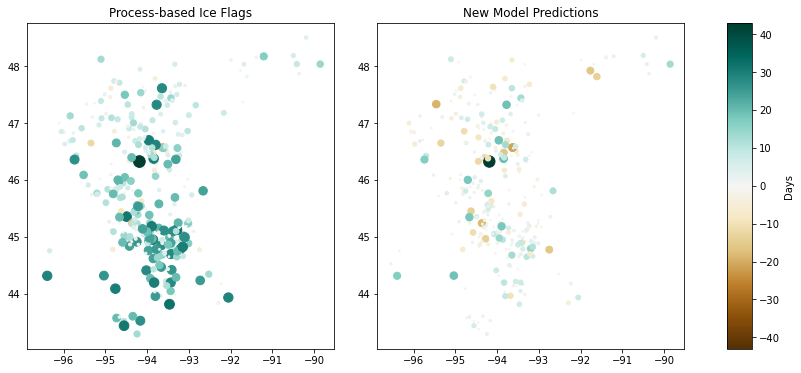

In [15]:
map_error('error_ice_on', 0.2)

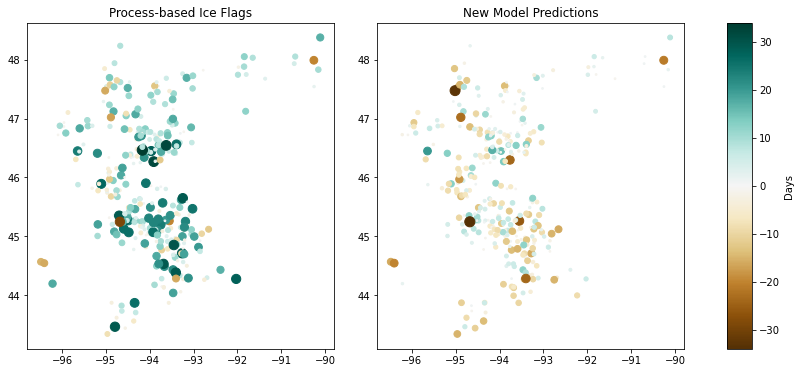

In [16]:
map_error('error_ice_off', 0.2)

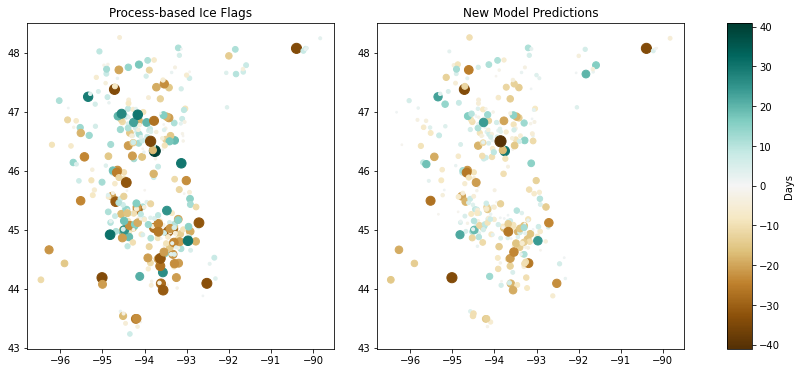

In [17]:
map_error('error_dur', 0.2)

# Do residuals significantly vary with certain lake characteristics?

Some additional evaluation for how residuals change with certain lake characteristics: lat, long, depth, and area. These residual-inspecting plots include a nonlinear correlation and p-value

In [18]:
def plot_and_print_resid_corr(values, label):
    
    # globally accessed mapping_df, assuming its column names (residuals), and associated axis labels
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    
    fig.suptitle('Correlation of Residuals with Static Lake Descriptions')

    ax[0].scatter(values, mapping_df['flag_error_ice_on'], alpha = 0.5, label = 'Process-based')
    ax[1].scatter(values, mapping_df['flag_error_ice_off'], alpha = 0.5)
    ax[2].scatter(values, mapping_df['flag_error_dur'], alpha = 0.5)
    ax[0].scatter(values, mapping_df['pred_error_ice_on'], alpha = 0.5, label = 'LSTM')
    ax[1].scatter(values, mapping_df['pred_error_ice_off'], alpha = 0.5)
    ax[2].scatter(values, mapping_df['pred_error_dur'], alpha = 0.5)
    ax[0].legend()

    ax[0].set_ylabel('Residual')
    ax[0].set_title('Ice on')
    ax[1].set_title('Ice off')
    ax[1].set_xlabel(label, fontsize = 12)
    ax[2].set_title('Ice duration')
    
    plt.show()

    print('\nProcess-based residual correlations')
    print('Ice on:\t\t', spearmanr(values, mapping_df['flag_error_ice_on']))
    print('Ice off:\t', spearmanr(values, mapping_df['flag_error_ice_off']))
    print('Ice duration:\t', spearmanr(values, mapping_df['flag_error_dur']))
    print('\nLSTM-based residual correlations')
    print('Ice on:\t\t', spearmanr(values, mapping_df['pred_error_ice_on']))
    print('Ice off:\t', spearmanr(values, mapping_df['pred_error_ice_off']))
    print('Ice duration:\t', spearmanr(values, mapping_df['pred_error_dur']), '\n')

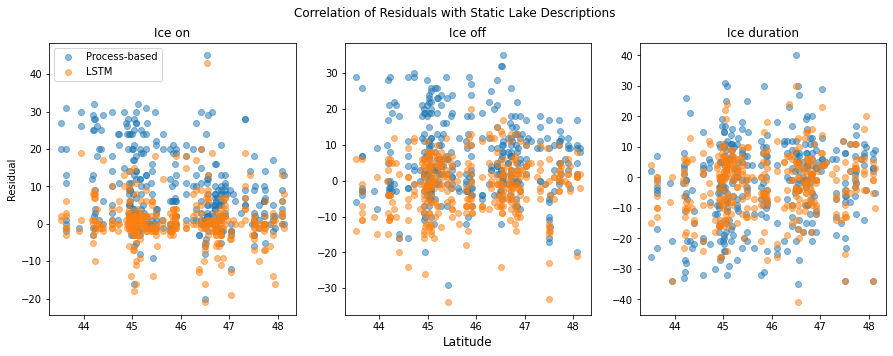


Process-based residual correlations
Ice on:		 SpearmanrResult(correlation=-0.23812289257222857, pvalue=6.6722299802438415e-06)
Ice off:	 SpearmanrResult(correlation=0.02034154732154713, pvalue=0.7045145648429307)
Ice duration:	 SpearmanrResult(correlation=0.1921403684762374, pvalue=0.00029976622031457044)

LSTM-based residual correlations
Ice on:		 SpearmanrResult(correlation=-0.09048728425381317, pvalue=0.09097530165010535)
Ice off:	 SpearmanrResult(correlation=0.1194089146159127, pvalue=0.025486810655501953)
Ice duration:	 SpearmanrResult(correlation=0.14180310214756697, pvalue=0.0078876559903942) 



In [19]:
plot_and_print_resid_corr(mapping_df['lat'], 'Latitude')

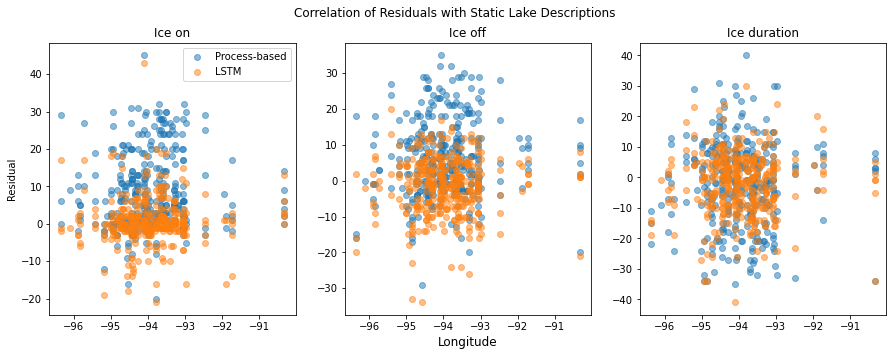


Process-based residual correlations
Ice on:		 SpearmanrResult(correlation=0.12466050507454475, pvalue=0.019650832697652464)
Ice off:	 SpearmanrResult(correlation=0.06681188520962039, pvalue=0.2124495336992866)
Ice duration:	 SpearmanrResult(correlation=-0.046904670176737426, pvalue=0.38165633511906927)

LSTM-based residual correlations
Ice on:		 SpearmanrResult(correlation=0.07621966023246055, pvalue=0.15476258743692478)
Ice off:	 SpearmanrResult(correlation=-0.008152420358323503, pvalue=0.8792068579497677)
Ice duration:	 SpearmanrResult(correlation=-0.03776949498774038, pvalue=0.48122967724703214) 



In [20]:
plot_and_print_resid_corr(mapping_df['long'], 'Longitude')

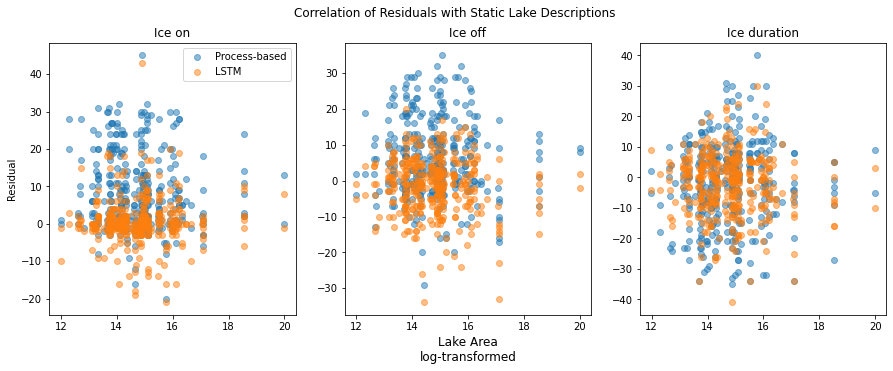


Process-based residual correlations
Ice on:		 SpearmanrResult(correlation=-0.09306570289578708, pvalue=0.08209694862366132)
Ice off:	 SpearmanrResult(correlation=0.011216072854286514, pvalue=0.8343784129260337)
Ice duration:	 SpearmanrResult(correlation=0.0672950434739604, pvalue=0.20915392279832182)

LSTM-based residual correlations
Ice on:		 SpearmanrResult(correlation=0.03524846204806797, pvalue=0.5109985740805044)
Ice off:	 SpearmanrResult(correlation=-0.060975347288019184, pvalue=0.25523641390955953)
Ice duration:	 SpearmanrResult(correlation=-0.07750968629109814, pvalue=0.1478790480466838) 



In [22]:
areas = test_x[:, 0, area_var_idx]

plot_and_print_resid_corr(areas, 'Lake Area\nlog-transformed')

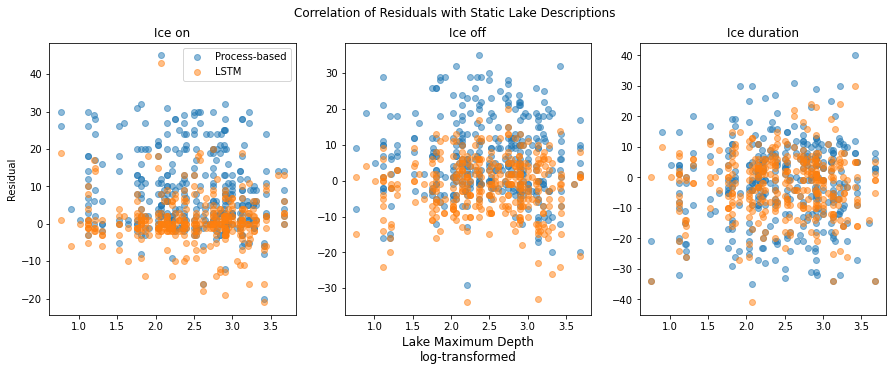


Process-based residual correlations
Ice on:		 SpearmanrResult(correlation=-0.1184347297425867, pvalue=0.026719737934237764)
Ice off:	 SpearmanrResult(correlation=-0.04199706358662482, pvalue=0.43349319906774675)
Ice duration:	 SpearmanrResult(correlation=0.06837651189217943, pvalue=0.20191124433502852)

LSTM-based residual correlations
Ice on:		 SpearmanrResult(correlation=0.04014059800661538, pvalue=0.45411210673226243)
Ice off:	 SpearmanrResult(correlation=-0.0072625190270418334, pvalue=0.8923074607105022)
Ice duration:	 SpearmanrResult(correlation=-0.018519238999376648, pvalue=0.7299038451657947) 



In [23]:
depths = test_x[:, 0, depth_var_idx]

plot_and_print_resid_corr(depths, 'Lake Maximum Depth\nlog-transformed')

## List of significant residual correlations

##### Latitude

* The process-based model's residuals are signficantly correlated with latitude on ice on and ice duration prediction. 
    * Negatively correlated for ice on, positively correlated for ice duration
* The massive lstm's residuals are significantly and positively correlated with latitude on ice duration prediction.
  
##### Longitude
  
* The process-based model's residuals are significantly and positively correlated with longitude for ice on prediction

##### Lake area

* No significant correlations.
    
##### Lake depth
    
* The process-based model's residuals are significantly and negatively correlated with lake depth on ice on prediction

### In total

* The process-based model's residuals are significantly correlated with static lake descriptions in 4/12 tested scenarios, half of these scenarios involve latitude.
* The massive lstm's residuals are significantly correlated with static lake descriptions in 1/12 tested scenarios - latitude and ice duration prediction.